This code uses functions from cwieder/sspa-in-metabolomics.

Repository URL: https://github.com/cwieder/sspa-in-metabolomics

Author(s): Wieder, Lai, and Ebbels (2022) 

License: GNU General Public License v3.0 (GPLv3)
The original code has been modified for this project.
The modified code follows the same GPLv3 license.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import os
import plotly.express as px
import seaborn as sns
import math
import scipy
import scipy.stats as ss

from scipy.stats import spearmanr
from sklearn.metrics.pairwise import nan_euclidean_distances 
import itertools
from itertools import tee
from itertools import permutations


import scipy as sp
from scipy import stats
import researchpy as rp
import scipy.stats as stat
import openpyxl

In [10]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,  RocCurveDisplay, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import scipy.stats as st
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error


In [11]:
key_modules_genes = pd.read_csv(f'key_modules_genes.csv')
key_modules_genes.set_index('Unnamed: 0', inplace=True)

In [4]:
from gseapy import Biomart
bm = Biomart()

results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'])
results.tail()

ensembl_gene_id external_gene_name  entrezgene_id       go_id
487072  ENSG00000289291                NaN           <NA>         NaN
487073  ENSG00000274978              RNU11          26824  GO:0030627
487074  ENSG00000274978              RNU11          26824  GO:0000395
487075  ENSG00000274978              RNU11          26824  GO:0005692
487076  ENSG00000296488                NaN           <NA>         NaN

# reactome pathways

In [12]:
 def process_reactome(name, infile, organism):
        # Process CHEBI to reactome data
        dir = r"/Users/edeneldar/CoExpression_reProduction/data"
        f = pd.read_csv(f"{dir}/{infile}", sep="\t", header=None)
        f.columns = ['ENSEMBL', 'pathway_ID', 'link', 'pathway_name', 'evidence_code', 'species']
        f_filt = f[f.species == organism]
        name_dict = dict(zip(f_filt['pathway_ID'], f_filt['pathway_name']))

        groups = f_filt.groupby(['pathway_ID'])['ENSEMBL'].apply(list).to_dict()
        df = pd.DataFrame.from_dict(groups, orient='index', dtype="object")

        pathways_df = df.dropna(axis=0, how='all', subset=df.columns.tolist()[1:])
        pathways = pathways_df.index.tolist()
        pathway_dict = {}

        for pathway in pathways:
            pathway_compounds = list(set(pathways_df.loc[pathway, :].tolist()))
            pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "None"]

            cpds = pathway_compounds[1:]
            if len(cpds) > 1:
                pathway_dict[pathway] = cpds
        return pathway_dict, name_dict, pathways_df

In [13]:
# Load Reactome pathway dictionary
pathway_dict, pathway_names, pathways_df = process_reactome("R76", "Ensembl2Reactome_All_Levels.tsv", "Homo sapiens")

# Remove large and uninformative pathways
remove_paths = ["R-HSA-1430728", "R-HSA-1643685", "R-HSA-382551"]
pathway_dict = {k: v for k, v in pathway_dict.items() if k not in remove_paths}


key_modules_data = key_modules_genes.iloc[:, :-2]
# Remove pathways not present in the dataset
compounds_present = key_modules_data.columns.tolist()
pathways_present = {k: v for k, v in pathway_dict.items() if len([i for i in compounds_present if i in v]) > 1}
print(len(pathways_present))
print(len(compounds_present))

905
1003


In [14]:
val_list = list(pathway_dict.values())
[i for i, lst in enumerate(val_list) if 'ENSG00000010610' in lst][0]

108

In [15]:
key_list = list(pathway_dict.keys())
val_list = list(pathway_dict.values())

position = [i for i, lst in enumerate(val_list) if 'ENSG00000010610' in lst][0]
print(key_list[position])


R-HSA-1280215


In [16]:
# list out keys and values separately
key_list = list(pathway_names.keys())
val_list = list(pathway_names.values())

position = key_list.index("R-HSA-1280215")
print(val_list[position])

Cytokine Signaling in Immune system


In [17]:
pathways_df['Pathway_name'] = pathways_df.index.map(pathway_names)

In [18]:
#all genes in pathways_present
all_pathway_mets = list(set([x for sublist in pathways_present.values() for x in sublist]))

md = key_modules_genes[["Group", "AGE"]]
key_modules_data_orig = key_modules_genes[key_modules_genes.columns.intersection(all_pathway_mets)]
key_modules_data_orig = pd.concat([key_modules_data_orig, md], axis=1)

key_modules_data_orig

ENSG00000204954  ENSG00000197971  ENSG00000197818  \
Unnamed: 0                                                      
GTEX-11EMC        -0.752841        -1.486007         0.942463   
GTEX-11GS4         0.851630        -0.455757         0.105058   
GTEX-11GSO        -1.355259        -0.571481         2.234688   
GTEX-11OF3         1.003392         0.231102        -0.046186   
GTEX-11ONC        -1.702728        -0.188466         1.123729   
...                     ...              ...              ...   
GTEX-T6MN         -0.388973         2.023956         0.187911   
GTEX-WL46          0.415246         0.921074        -1.155905   
GTEX-YFC4          0.957512         0.806960         0.000847   
GTEX-ZAK1          0.560914         0.162599        -0.799299   
GTEX-ZUA1         -0.344806         0.113458        -0.483354   

            ENSG00000197361  ENSG00000196569  ENSG00000196470  \
Unnamed: 0                                                      
GTEX-11EMC        -1.260865         1.021034         0.341458   
GTEX-11GS4         0.351689        -1.444680         0.203571   
GTEX-11GSO        -1.263283        -0.324241         0.991913   
GTEX-11OF3         0.737194        -1.144417        -0.960339   
GTEX-11ONC        -1.115462         0.139937         0.625903   
...                     ...              ...              ...   
GTEX-T6MN         -0.313056        -0.106783        -1.105277   
GTEX-WL46         -0.184872         0.001594        -0.568484   
GTEX-YFC4         -1.133575        -2.002841        -0.021293   
GTEX-ZAK1         -0.126880        -1.256150         0.188891   
GTEX-ZUA1          0.705665        -0.899113        -1.186205   

            ENSG00000188677  ENSG00000186480  ENSG00000185989  \
Unnamed: 0                                                      
GTEX-11EMC        -0.271540        -0.624822         0.404978   
GTEX-11GS4         0.914300         0.475690        -1.274745   
GTEX-11GSO        -0.116604        -0.093312         1.449244   
GTEX-11OF3         0.761867        -0.290200         0.567676   
GTEX-11ONC        -1.095502         0.304555         0.431398   
...                     ...              ...              ...   
GTEX-T6MN          0.144457        -0.619772        -0.092767   
GTEX-WL46          0.812830        -1.265807         0.389793   
GTEX-YFC4          0.462469        -0.927885         0.705992   
GTEX-ZAK1          1.962869         0.688816        -1.290315   
GTEX-ZUA1         -0.217989        -1.396255         0.275926   

            ENSG00000185760  ...  ENSG00000122862  ENSG00000122254  \
Unnamed: 0                   ...                                     
GTEX-11EMC         0.713028  ...        -0.812185         0.804741   
GTEX-11GS4        -0.958620  ...         0.535089        -0.347366   
GTEX-11GSO         1.071746  ...        -0.259460         1.887318   
GTEX-11OF3        -1.442245  ...         0.215573        -0.433508   
GTEX-11ONC         1.050609  ...         0.105141         0.594795   
...                     ...  ...              ...              ...   
GTEX-T6MN         -0.806934  ...        -0.715091         0.065873   
GTEX-WL46         -1.815073  ...        -0.409066        -0.679098   
GTEX-YFC4         -0.806310  ...        -0.075211        -1.220887   
GTEX-ZAK1          1.026534  ...         0.540346        -1.833345   
GTEX-ZUA1          0.266583  ...        -0.093582        -0.684181   

            ENSG00000120889  ENSG00000120833  ENSG00000117394  \
Unnamed: 0                                                      
GTEX-11EMC        -0.045281        -0.553753         0.279047   
GTEX-11GS4         1.230357        -0.648118        -0.570422   
GTEX-11GSO        -0.674426        -0.635149        -0.602942   
GTEX-11OF3        -0.917911        -1.711201         0.942315   
GTEX-11ONC         0.424053         0.105315         2.204590   
...                     ...              ...              ...   
GTEX-T6MN         -0.024905        -0.47476

In [19]:
from sklearn.decomposition import PCA, KernelPCA
def kpca_res(mat, pathways):
    pathway_matrices = []
    pathway_ids = []
    for pathway, compounds in pathways.items():
        single_pathway_matrix = mat.drop(mat.columns.difference(compounds), axis=1)
        if single_pathway_matrix.shape[1] >= 1:
            pathway_matrices.append(single_pathway_matrix.values)
            pathway_ids.append(pathway)

    scores = []
    for n, m in enumerate(pathway_matrices):
        kpca = KernelPCA(n_components=2, kernel="rbf")
        new_data = kpca.fit_transform(m)
        scores.append(new_data[:, 0])
    scores_df = pd.DataFrame(scores, columns=mat.index, index=pathways.keys())
    return scores_df

In [20]:
scores = kpca_res(key_modules_genes.iloc[:, :-2], pathways_present).T
scores

R-HSA-1059683  R-HSA-109581  R-HSA-109582  R-HSA-109606  \
Unnamed: 0                                                            
GTEX-11EMC       0.287018     -0.511242     -0.465043     -0.336782   
GTEX-11GS4      -0.315471      0.242127      0.243967      0.458281   
GTEX-11GSO      -0.503342     -0.304683     -0.162149     -0.071204   
GTEX-11OF3      -0.379908      0.573492      0.347851      0.654286   
GTEX-11ONC      -0.382400      0.031352     -0.005244      0.251875   
...                   ...           ...           ...           ...   
GTEX-T6MN       -0.302846      0.265764      0.547641      0.471202   
GTEX-WL46       -0.473287      0.496313      0.345575      0.620657   
GTEX-YFC4       -0.136497      0.364056      0.480749      0.450552   
GTEX-ZAK1        0.001778      0.340943      0.084424      0.450597   
GTEX-ZUA1       -0.273386      0.361929      0.253458      0.384580   

            R-HSA-109704  R-HSA-110056  R-HSA-111885  R-HSA-112040  \
Unnamed: 0                                                           
GTEX-11EMC      0.340985      0.239668     -0.484925     -0.436819   
GTEX-11GS4     -0.180666     -0.307933      0.352001      0.447372   
GTEX-11GSO     -0.167818     -0.441812     -0.418941     -0.618569   
GTEX-11OF3     -0.386999     -0.404909      0.115414      0.052731   
GTEX-11ONC      0.014706     -0.169057     -0.295113     -0.319392   
...                  ...           ...           ...           ...   
GTEX-T6MN      -0.024192     -0.328208      0.579853      0.646606   
GTEX-WL46      -0.433311     -0.497137      0.496243      0.543034   
GTEX-YFC4      -0.270806     -0.143823      0.598136      0.683958   
GTEX-ZAK1      -0.205749      0.028892      0.073706      0.452929   
GTEX-ZUA1      -0.302922     -0.236302      0.225532      0.470718   

            R-HSA-112043  R-HSA-112310  ...  R-HSA-9924644  R-HSA-9925563  \
Unnamed: 0                              ...                                 
GTEX-11EMC     -0.436819     -0.331528  ...       0.721807       0.429015   
GTEX-11GS4      0.447372      0.520562  ...      -0.505434      -0.430532   
GTEX-11GSO     -0.618569     -0.237367  ...       0.736893       0.319564   
GTEX-11OF3      0.052731      0.386236  ...      -0.569107      -0.419192   
GTEX-11ONC     -0.319392      0.007832  ...      -0.113608       0.177324   
...                  ...           ...  ...            ...            ...   
GTEX-T6MN       0.646606      0.588349  ...      -0.414957      -0.576740   
GTEX-WL46       0.543034      0.646088  ...      -0.333789      -0.329598   
GTEX-YFC4       0.683958      0.553552  ...      -0.368287      -0.400777   
GTEX-ZAK1       0.452929      0.239997  ...      -0.467113      -0.070570   
GTEX-ZUA1       0.470718      0.356992  ...      -0.455112      -0.472961   

            R-HSA-9926550  R-HSA-9927020  R-HSA-9927432  R-HSA-9931509  \
Unnamed: 0                                                               
GTEX-11EMC      -0.609706       0.758614       0.721807      -0.501328   
GTEX-11GS4       0.312331       0.721468      -0.505434       0.124200   
GTEX-11GSO       0.044986      -0.566628       0.736893      -0.414045   
GTEX-11OF3       0.689791      -0.569777      -0.569107       0.443058   
GTEX-11ONC       0.085891       0.480858      -0.113608      -0.047535   
...                   ...            ...            ...            ...   
GTEX-T6MN        0.636988      -0.536033      -0.414957       0.703160   
GTEX-WL46        0.568439      -0.582380      -0.333789       0.551397   
GTEX-YFC4        0.659889      -0.443835      -0.368287       0.483543   
GTEX-ZAK1       -0.523501      -0.074541      -0.467113       0.552103   
GTEX-ZUA1        0.323520       0.668432      -0.455112       0.281655   

            R-HSA-9931953  R-HSA-9933387  R-HSA-9937080  R-HSA-997272  
Unnamed: 0                                                             
GTEX-11EMC       0.585216      -0.559369      -0.549871      0.06335

In [21]:
import statsmodels.api as sm

def t_tests(matrix, classes, multiple_correction_method, testtype="ttest"):
    metabolites = matrix.columns.tolist()
    matrix['Target'] = pd.factorize(classes)[0]
    disease = matrix.loc[matrix["Target"] == 0]
    disease.drop(['Target'], axis=1, inplace=True)
    ctrl = matrix.loc[matrix["Target"] != 0]
    ctrl.drop(['Target'], axis=1, inplace=True)
    if testtype == "mwu":
        pvalues = stats.mannwhitneyu(disease, ctrl, axis=0)[1]
    else:
        pvalues = stats.ttest_ind(disease, ctrl)[1]
        
    print(len(pvalues))
    padj = sm.stats.multipletests(pvalues, 0.05, method=multiple_correction_method)
    results = pd.DataFrame(zip(metabolites, pvalues, padj[1]),
                           columns=["Pathway", "P-value", "P-adjust"])
    return results

In [22]:
de_res_path = t_tests(scores, key_modules_genes["Group"], "fdr_bh")
de_res_path

905


/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T/ipykernel_73670/559694277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease.drop(['Target'], axis=1, inplace=True)
/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T/ipykernel_73670/559694277.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl.drop(['Target'], axis=1, inplace=True)


Pathway   P-value  P-adjust
0    R-HSA-1059683  0.771302  0.812606
1     R-HSA-109581  0.311832  0.509777
2     R-HSA-109582  0.238665  0.446706
3     R-HSA-109606  0.279593  0.486942
4     R-HSA-109704  0.515459  0.636412
..             ...       ...       ...
900  R-HSA-9931509  0.235573  0.445081
901  R-HSA-9931953  0.195499  0.431208
902  R-HSA-9933387  0.157565  0.415498
903  R-HSA-9937080  0.325159  0.518078
904   R-HSA-997272  0.036913  0.404928

[905 rows x 3 columns]

In [23]:
top50paths = de_res_path.sort_values(by="P-adjust")["Pathway"].tolist()[0:50]
scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, key_modules_genes[["Group"]]], axis=1)

colours = sns.color_palette("tab10")

group_dict = {"young":"lightseagreen", "old":"lightcoral"}
#row_cols = dict(zip(key_modules_genes.index, [colors_dict[i] for i in key_modules_genes["AGE"]]))
row_cols2 = dict(zip(key_modules_genes.index, [group_dict[i] for i in key_modules_genes["Group"]]))

print(group_dict)

{'young': 'lightseagreen', 'old': 'lightcoral'}


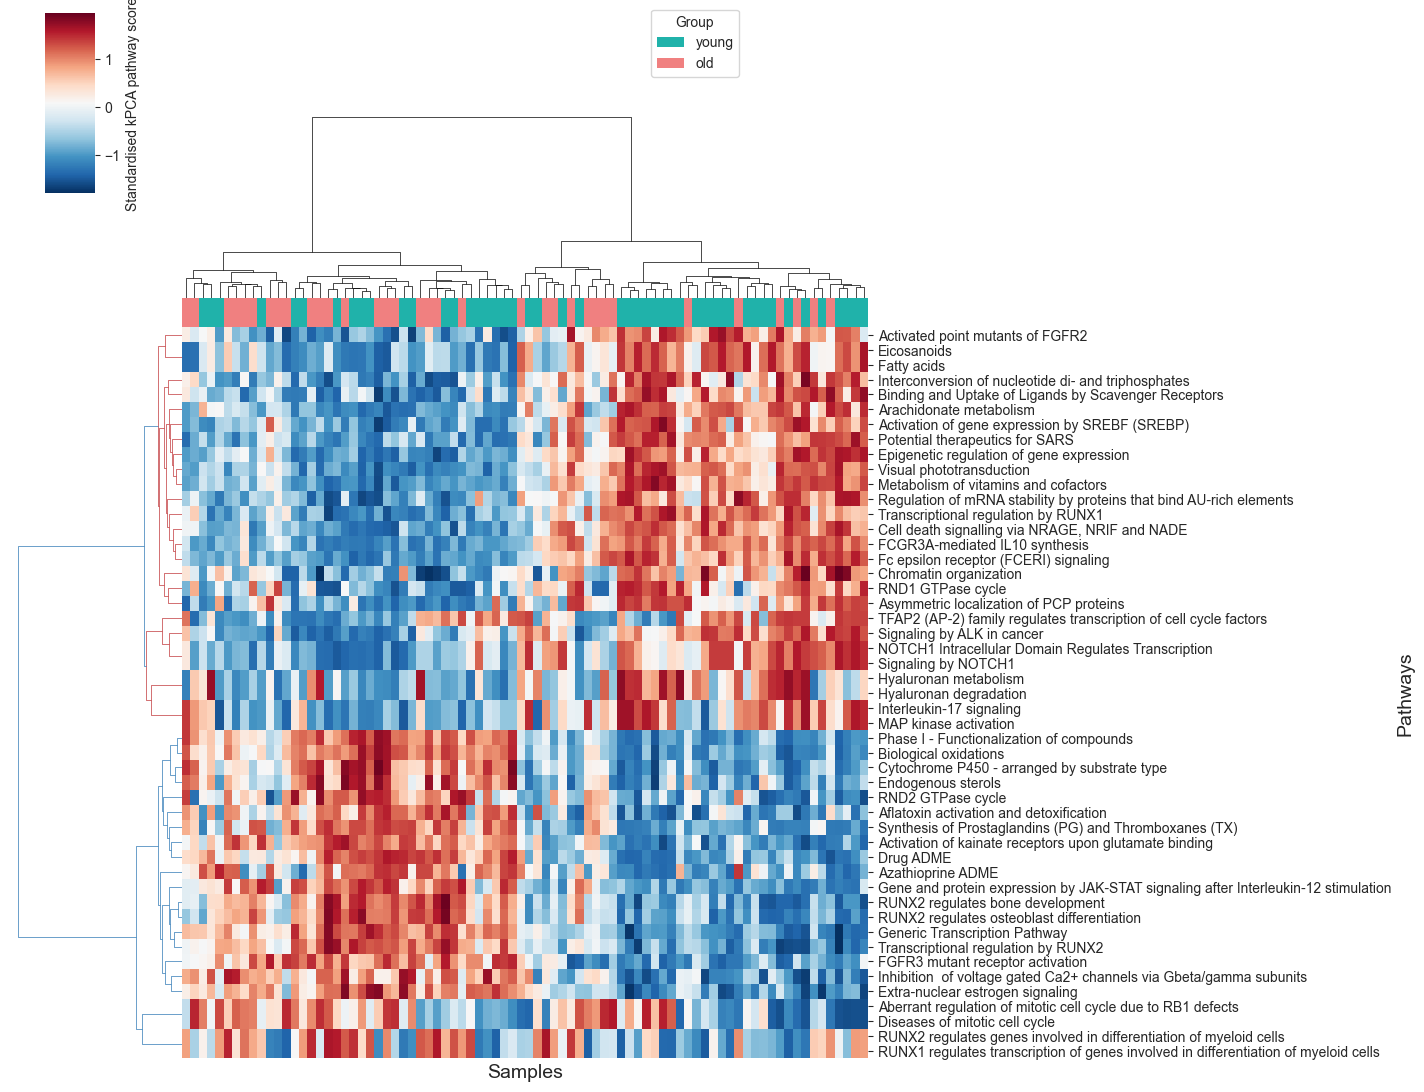

In [24]:
#col_cols = key_modules_genes.index.map(row_cols)
col_cols2 = key_modules_genes.index.map(row_cols2)
sns.set_style("ticks")
g = sns.clustermap(scores_df.iloc[:, :-2].T,
               z_score=0,
               col_colors=[col_cols2],
               method="ward",
              yticklabels=True,
              xticklabels=False,
                  cmap="RdBu_r",
                  cbar_kws={'label': 'Standardised kPCA pathway score'},
                  cbar_pos=(0.05, 0.9, 0.05, 0.18),
                  tree_kws={'colors':'black'})
dendro_cols = sns.color_palette("RdBu_r")
g.ax_heatmap.set_xlabel("Samples", fontsize=14)
g.ax_heatmap.set_ylabel("Pathways", fontsize=14)

top50_dict = dict(zip(range(0, 50), top50paths))
top50_map = [top50_dict[i] for i in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_yticklabels([pathway_names[i] for i in top50_map])

# legends 
from matplotlib.pyplot import gcf

age = ["old", "young"]
#group_dict = {"young":"red", "old":"green"}
dendro_cols = sns.color_palette("RdBu_r")
for label in list(set(key_modules_genes["Group"])):
    g.ax_row_dendrogram.bar(0, 0, color=group_dict[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Group', loc="center", ncol=1, bbox_to_anchor=(0.7, 1.05), bbox_transform=gcf().transFigure)

# set dendrogram colours
for l in g.ax_row_dendrogram.collections:
    l.set_edgecolor([dendro_cols[5] for i in range(0, 25)] + [dendro_cols[0] for i in range(0, 25)] )
    

plt.savefig(f"plots/ssGSEA_Clustered_heatmap.png", bbox_inches='tight', dpi=300)


plt.show()

# single sample pathway analysis

In [25]:
# macOS R 4.5 ARM64 configuration
import os

# Set R_HOME to your R installation (note the capitalization in Resources)
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources'

os.environ['R_USER'] = '/opt/anaconda3/envs/new_base/lib/python3.1/site-packages/rpy2'
# Import rpy2 and related modules
import rpy2.rinterface as rinterface
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import conversion, default_converter

# Import GSVA
with conversion.localconverter(default_converter):
    gsva_r = importr('GSVA')
    print(gsva_r)

rpy2.robjects.packages.Package as a <module 'GSVA'>


In [4]:
import rpy2.rinterface as rinterface


In [5]:
import os
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
import rpy2.robjects as ro

/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T//RtmpiTHK9H", R: "/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T//Rtmp2sbD6H"
  warnings.warn(


In [ ]:
# #pip install WinPython
# #pip install rpy2==3.5.11

# # user defined R installation
# import os
# os.environ['R_HOME'] = r'C:\Program Files\R\R-4.3.1' #path to your R installation
# os.environ['R_USER'] = r'C:\Users\brsha\anaconda3\Lib\site-packages\rpy2' #path depends on where you installed Python.

# import rpy2
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import conversion, default_converter

# with conversion.localconverter(default_converter):
#     gsva_r = importr('GSVA')
#     print(gsva_r)

NotADirectoryError: [Errno 20] Not a directory: '/opt/anaconda3/bin/r/bin/Rscript'

In [35]:
def ssgsea_results(mat, pathways):
    with conversion.localconverter(default_converter):
        base = importr('base')
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_mat = ro.conversion.py2rpy(mat.iloc[:, :-1].T)
        r_mat = base.as_matrix(r_mat)  # abundance matrix
        row_vec = base.as_character(mat.columns[:-1].tolist())
        r_mat.rownames = row_vec
        r_list = ro.ListVector(pathways)  # pathways
        gsva_r = importr('GSVA')
        gsva_res = gsva_r.gsva(r_mat, r_list, method="ssgsea")
        with localconverter(ro.default_converter + pandas2ri.converter):
            gsva_df = ro.conversion.rpy2py(gsva_res)
        ssgsea_scores = pd.DataFrame(gsva_df, index=pathways.keys(), columns=mat.iloc[:, :-1].index.tolist())
        return ssgsea_scores


In [37]:
def ssgsea_results(mat, pathways):
    """
    Run ssGSEA (GSVA >= 2.0 API) on a pandas DataFrame
    --------------------------------------------------
    * `mat`:  samples × genes (or genes × samples, see transpose below)
    * `pathways`: dict {pathway_name: list_of_genes}
    Returns a DataFrame pathways × samples with ssGSEA scores.
    """
    import pandas as pd
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects.packages import importr

    pandas2ri.activate()

    # R helpers
    base = importr("base")
    gsva = importr("GSVA")

    # ----- 1. Expression matrix (genes in rows) --------------------------
    expr = mat.iloc[:, :-1].T       # genes (rows) × samples (cols)
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_expr = ro.conversion.py2rpy(expr)
    r_expr = base.as_matrix(r_expr) # make sure it's a plain numeric matrix

    # ----- 2. Gene-set list ---------------------------------------------
    r_gsets = ro.ListVector({k: ro.StrVector(v) for k, v in pathways.items()})

    # ----- 3. ssGSEA parameter object (new API) --------------------------
    ssgsea_param = gsva.ssgseaParam()        # <- NEW

    # ----- 4. Run gsva() --------------------------------------------------
    r_res = gsva.gsva(ssgsea_param, r_expr, r_gsets)   # <- NEW order

    # ----- 5. Back to pandas ---------------------------------------------
    with localconverter(ro.default_converter + pandas2ri.converter):
        res_df = ro.conversion.rpy2py(r_res)

    res_df = pd.DataFrame(res_df,
                          index=list(pathways.keys()),
                          columns=expr.columns)
    return res_df


In [31]:
def ssgsea_results(mat, pathways):
    with conversion.localconverter(default_converter):
        base = importr('base')
        # First convert the data to R format
        with localconverter(ro.default_converter + pandas2ri.converter):
            expr_matrix = ro.conversion.py2rpy(mat.iloc[:, :-1].T)
        
        # Import required packages
        biobase = importr('Biobase')
        gsva_r = importr('GSVA')
        
        # Use R code directly to handle the complex workflow
        r_code = """
        function(expr_matrix, gene_sets) {
            # Convert matrix and ensure proper dimensions
            expr_matrix <- as.matrix(expr_matrix)
            
            # Create ExpressionSet directly without setting rownames/colnames
            # (they will be set by the conversion process)
            expr_set <- Biobase::ExpressionSet(assayData=expr_matrix)
            
            # Run GSVA
            result <- GSVA::gsva(expr_set, gene_sets, method="ssgsea")
            
            # Extract results
            return(Biobase::exprs(result))
        }
        """
        r_func = ro.r(r_code)
        
        # Convert pathway dictionary to R list
        r_list = ro.ListVector(pathways)
        
        # Run the R function
        gsva_res = r_func(expr_matrix, r_list)
        
        # Convert back to Python
        with localconverter(ro.default_converter + pandas2ri.converter):
            gsva_df = ro.conversion.rpy2py(gsva_res)
        
        # Format as DataFrame
        ssgsea_scores = pd.DataFrame(gsva_df, 
                                    index=pathways.keys(), 
                                    columns=mat.iloc[:, :-1].index.tolist())
        return ssgsea_scores

In [33]:
def ssgsea_results(mat, pathways):
    """
    Run ssGSEA analysis using temporary files to exchange data with R.
    More robust than direct rpy2 calls for complex Bioconductor workflows.
    """
    import tempfile
    import os
    import subprocess
    import json
    
    # Create temporary directory for data exchange
    temp_dir = tempfile.mkdtemp()
    data_path = os.path.join(temp_dir, "expr_data.csv")
    pathway_path = os.path.join(temp_dir, "pathways.json")
    results_path = os.path.join(temp_dir, "results.csv")
    r_script_path = os.path.join(temp_dir, "run_gsva.R")
    
    try:
        # Save expression data to CSV
        expr_data = mat.iloc[:, :-1].T
        expr_data.to_csv(data_path)
        
        # Save pathways as JSON
        with open(pathway_path, 'w') as f:
            json.dump(pathways, f)
        
        # Create R script
        r_script = f"""
        # Load libraries
        library(Biobase)
        library(GSVA)
        library(jsonlite)
        
        # Read data
        expr_data <- read.csv("{data_path}", row.names=1)
        expr_matrix <- as.matrix(expr_data)
        gene_sets <- fromJSON("{pathway_path}")
        
        # Create ExpressionSet
        expr_set <- ExpressionSet(assayData=expr_matrix)
        
        # Run GSVA
        result <- gsva(expr_set, gene_sets, method="ssgsea")
        
        # Save results
        write.csv(exprs(result), "{results_path}")
        """
        
        # Save R script
        with open(r_script_path, 'w') as f:
            f.write(r_script)
        
        # Run R script
        process = subprocess.run(
            ["Rscript", r_script_path],
            capture_output=True,
            text=True
        )
        
        if process.returncode != 0:
            print("R Error:", process.stderr)
            raise Exception(f"R script failed: {process.stderr}")
        
        # Read results
        if os.path.exists(results_path):
            results_df = pd.read_csv(results_path, index_col=0)
            ssgsea_scores = pd.DataFrame(
                results_df.values,
                index=results_df.index,
                columns=mat.iloc[:, :-1].index.tolist()
            )
            return ssgsea_scores
        else:
            raise Exception("GSVA results file was not created")
    
    finally:
        # Clean up temp files
        for file_path in [data_path, pathway_path, results_path, r_script_path]:
            if os.path.exists(file_path):
                os.remove(file_path)
        if os.path.exists(temp_dir):
            os.rmdir(temp_dir)

In [42]:
def ssgsea_results(mat, pathways):
    """
    Run single-sample GSEA (GSVA ≥ 2.0 API).

    Parameters
    ----------
    mat : pd.DataFrame
        Samples × genes (last two cols are Group / AGE and are ignored).
    pathways : dict[str, list[str]]
        { pathway_name : [gene1, gene2, …] }

    Returns
    -------
    pd.DataFrame
        Pathways × samples ssGSEA score matrix.
    """
    import pandas as pd
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2.robjects.conversion import localconverter

    # ---------------- R helpers ----------------
    base = importr("base")
    gsva = importr("GSVA")

    # ---------- 1. expression matrix -----------
    expr = mat.iloc[:, :-1].T                       # genes × samples
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_expr = ro.conversion.py2rpy(expr)
    r_expr = base.as_matrix(r_expr)

    # ---------- 2. gene-set list ---------------
    r_gsets = ro.ListVector({k: ro.StrVector(v)
                             for k, v in pathways.items()})

    # ---------- 3. build ssGSEA param ----------
    ssgsea_param = gsva.ssgseaParam(r_expr, r_gsets)   # <- key change

    # ---------- 4. run the analysis ------------
    r_scores = gsva.gsva(ssgsea_param)                # param-only call

    # ---------- 5. back to pandas --------------
    with localconverter(ro.default_converter + pandas2ri.converter):
        scores = ro.conversion.rpy2py(r_scores)

    return pd.DataFrame(scores,
                        index=list(pathways.keys()),
                        columns=expr.columns)


In [43]:
scores_gsea = ssgsea_results(key_modules_data_orig.iloc[:, :-2],
                             pathways_present).T

ℹ GSVA version 2.2.0
ℹ Calculating  ssGSEA scores for 905 gene sets
ℹ Calculating ranks
ℹ Calculating rank weights
ℹ Normalizing ssGSEA scores
✔ Calculations finished


In [ ]:
scores_df_gsea

In [45]:
# pathway level
scores_gsea = ssgsea_results(key_modules_data_orig.iloc[:, :-2], pathways_present).T
de_res_path_gsea = t_tests(scores_gsea, key_modules_data_orig["Group"], "fdr_bh")
top50paths_gsea = de_res_path_gsea.sort_values(by="P-adjust")["Pathway"].tolist()[0:50]
scores_gsea = scores_gsea.loc[:, top50paths_gsea]
scores_df_gsea = pd.concat([scores_gsea, key_modules_data_orig[["Group", "AGE"]]], axis=1)

skf_p = StratifiedKFold(n_splits=3)
X_p = scores_df_gsea.iloc[:, :-2].to_numpy()
y_p = scores_df_gsea["Group"]
clf_p = RandomForestClassifier()
print(cross_val_score(clf_p, X_p, y_p, cv=skf_p, scoring="roc_auc"))

ℹ GSVA version 2.2.0
ℹ Calculating  ssGSEA scores for 905 gene sets
ℹ Calculating ranks
ℹ Calculating rank weights
ℹ Normalizing ssGSEA scores
✔ Calculations finished
905


/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T/ipykernel_73670/559694277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease.drop(['Target'], axis=1, inplace=True)
/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T/ipykernel_73670/559694277.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl.drop(['Target'], axis=1, inplace=True)


[0.6953125  0.67329545 0.78693182]


## Random Forest with ssGSEA

In [46]:
key_modules_genes_selected = pd.read_csv("key_modules_genes_selected.csv")
key_modules_genes_selected.set_index('Unnamed: 0', inplace=True)

In [55]:
def plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc):
    plt.figure(figsize=(7,7))
    plt.style.use("seaborn-v0_8")
    plt.plot(base_fpr, mean_tprs, 'b', label=f'AUC = {roc_auc:.3f}')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1],'r--', label='Random')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC Curve for RF classifier')

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"plots/roc_curve_Random Forest.png", dpi=300)
    plt.show()

In [56]:
def aging_classification (df, model):

    skf = StratifiedKFold(n_splits=5)
    X = df.iloc[:, :-2].to_numpy()
    y = pd.factorize(df["Group"])[0]

    base_fpr = np.linspace(0, 1, 101)
    roc_all = []
    tprs = []
    aurocs = []

    accs, precs, recs, f1s = [], [], [], []


    # configure the cross-validation procedure
    skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in skf_outer.split(X,y):
     # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        # configure the cross-validation procedure
        skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

        if(model== 'xgboost'):
            model_tune = xgb.XGBClassifier()
            random_grid = {'n_estimators': [100, 150, 200, 250, 300] ,
                            'max_depth': [6, 8, 10, 12],
                            'learning_rate':[.3, .1, .03, .01, .003, .001],
                            #"min_child_weight": [1, 2, 4, 8] ,
                            "colsample_bytree": [.8, .9, 1.0],
                            "subsample": [.8, .9, 1.0]}


        if(model== 'RF'):
            model_tune = RandomForestClassifier()
            random_grid = { 'n_estimators': [100, 150, 200, 250, 300] ,
                           'max_features': ['auto', 'sqrt', 'log2'],
                           'max_depth' : [4,5,6,7,8, 10, 12],
                           'criterion' :['gini', 'entropy']}
            
        scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
        # define search
        model_hyper = RandomizedSearchCV(model_tune,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                       n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
        # execute search
        result = model_hyper.fit(X_train, y_train)

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        # store the result
        outer_results.append(acc)
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))

        accs.append(accuracy_score(y_test, yhat))
        precs.append(precision_score(y_test, yhat))
        recs.append(recall_score(y_test, yhat))
        f1s.append(f1_score(y_test, yhat))   
        fpr, tpr, _ = roc_curve(y_test, model_hyper.predict_proba(X_test)[:,1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)


    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
    roc_auc = auc(base_fpr, mean_tprs)
    print(f'Mean AUC: {np.mean(roc_auc)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

    plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.529, est=0.735, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.647, est=0.680, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.625, est=0.665, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.688, est=0.711, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.750, est=0.669, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
nan accuracy with a standard deviation of nan
Mean AUC: 0.7220666666666667, Mean Accuracy: 0.6477941176470589, Mean Precision: 0.6533333333333333, Mean Recall: 0.8577777777777778, Mean F1: 0.7387445887445888


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


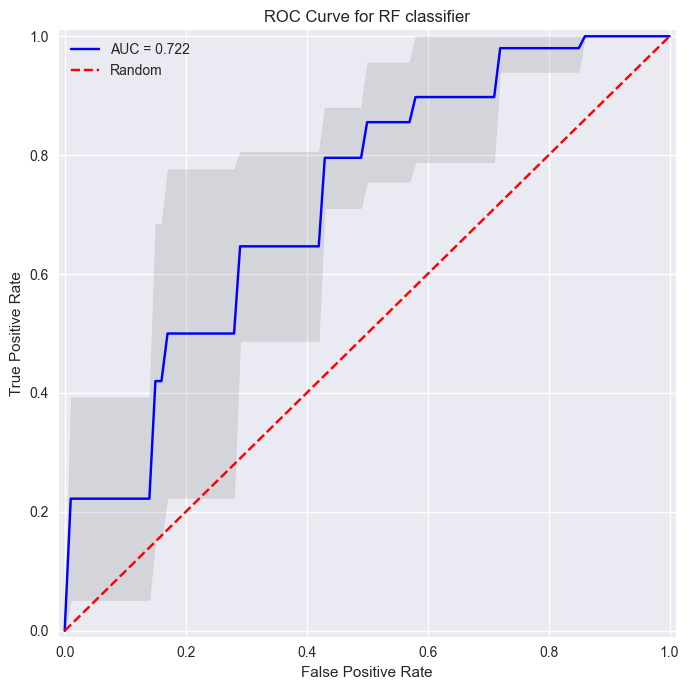

Accuracy: 0.648 (0.073)


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.647, est=0.886, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.882, est=0.933, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.625, est=0.875, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.812, est=0.879, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.938, est=0.860, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
0.88 accuracy with a standard deviation of 0.09
Mean AUC: 0.8817853333333334, Mean Accuracy: 0.7808823529411765, Mean Precision: 0.7518181818181818, Mean Recall: 0.96, Mean F1: 0.8391774891774892
Accuracy: 0.781 (0.125)


In [57]:
# met level with RF  

aging_classification(key_modules_genes, 'RF')

labels = pd.factorize(key_modules_genes["Group"])[0]

skf = StratifiedKFold(n_splits=5)
X = key_modules_genes_selected.iloc[:, :-2].to_numpy()
y = labels

base_fpr = np.linspace(0, 1, 101)
roc_all = []
tprs = []
aurocs = []

accs, precs, recs, f1s = [], [], [], []


# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier()

    random_grid = { 
    'n_estimators': [100, 150, 200, 250, 300] ,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10, 12],
    'criterion' :['gini', 'entropy']
}
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    model_hyper = RandomizedSearchCV(model,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = model_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   
    fpr, tpr, _ = roc_curve(y_test, model_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    aurocs.append(roc_auc_score(y_test, model_hyper.predict_proba(X_test)[:, 1]))
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc = auc(base_fpr, mean_tprs)
print(f'Mean AUC: {np.mean(roc_auc)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [54]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.588, est=0.747, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.706, est=0.683, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.625, est=0.657, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.812, est=0.694, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.750, est=0.650, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
nan accuracy with a standard deviation of nan
Mean AUC: 0.6825293333333333, Mean Accuracy: 0.6963235294117647, Mean Precision: 0.6927272727272727, Mean Recall: 0.8800000000000001, Mean F1: 0.7707792207792208


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


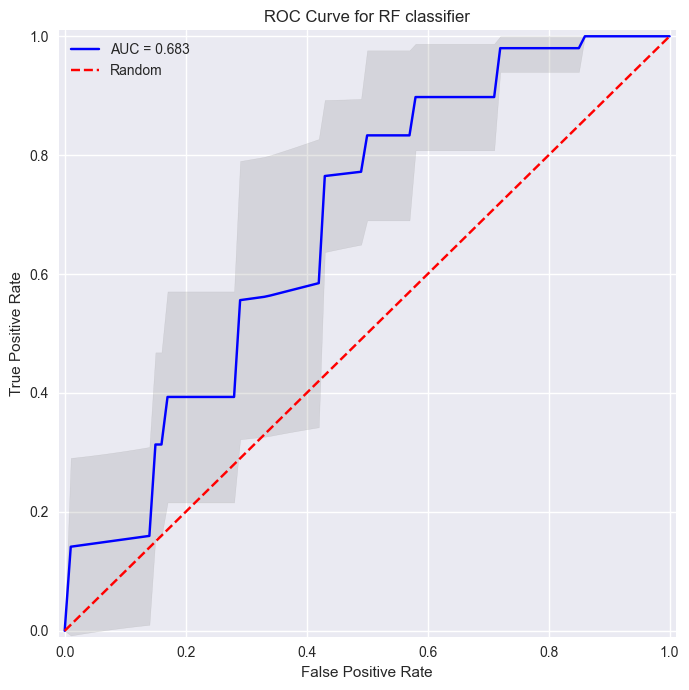

Accuracy: 0.696 (0.082)


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.588, est=0.779, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.824, est=0.733, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.812, est=0.769, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.750, est=0.806, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constr

>acc=0.750, est=0.844, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
0.82 accuracy with a standard deviation of 0.12
Mean AUC: 0.7949555555555556, Mean Accuracy: 0.7448529411764706, Mean Precision: 0.7606060606060605, Mean Recall: 0.8355555555555556, Mean F1: 0.7923748765854028
Accuracy: 0.745 (0.084)


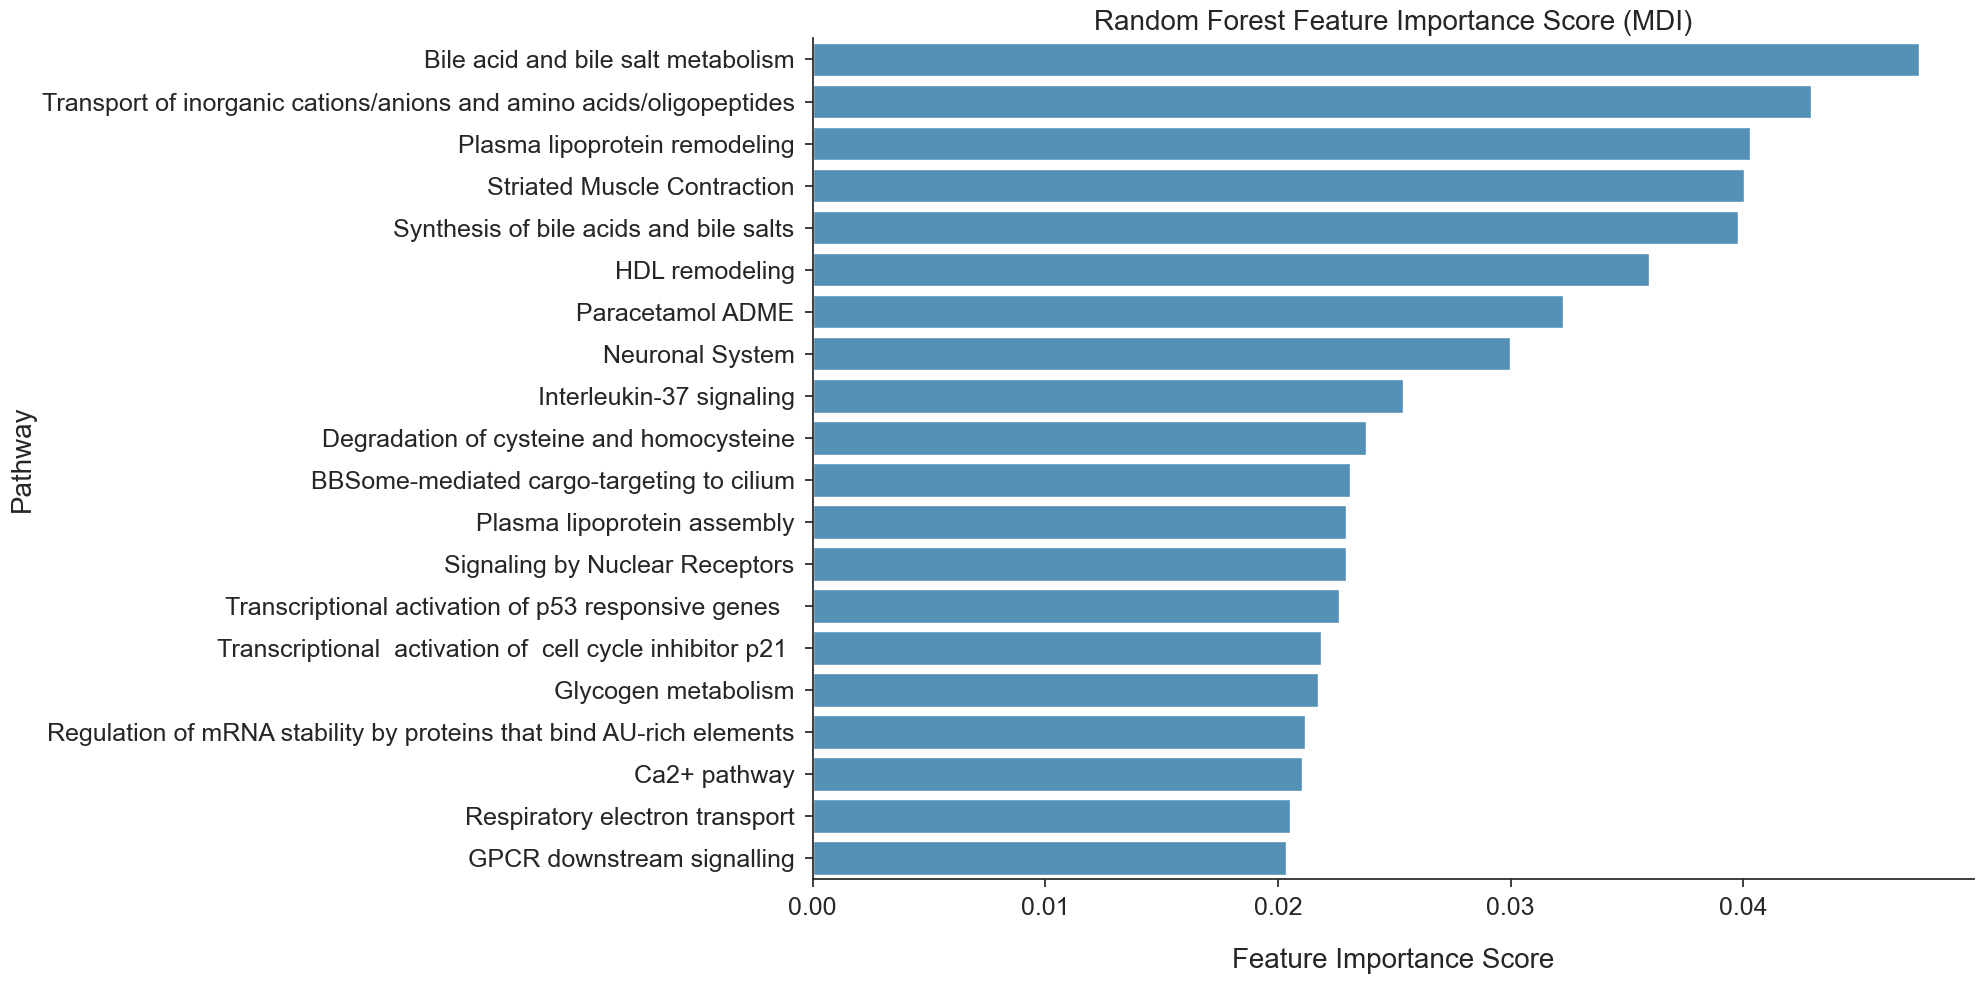

In [65]:
# pathway level with RF

aging_classification(key_modules_genes, 'RF')

labels = pd.factorize(key_modules_genes["Group"])[0]

skf = StratifiedKFold(n_splits=5)
X = scores_df_gsea.iloc[:, :-2].to_numpy()
y = labels

base_fpr_p = np.linspace(0, 1, 101)
roc_all_p = []
tprs_p = []
aurocs_p = []

accs, precs, recs, f1s = [], [], [], []

importances_per_fold = []

# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier()

    random_grid = { 
    'n_estimators': [100, 150, 200, 250, 300] ,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10, 12],
    'criterion' :['gini', 'entropy']
}
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    model_hyper = RandomizedSearchCV(model,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = model_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   
    fpr, tpr, _ = roc_curve(y_test, model_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr_p, fpr, tpr)
    tpr[0] = 0.0
    tprs_p.append(tpr)
    aurocs_p.append(roc_auc_score(y_test, model_hyper.predict_proba(X_test)[:, 1]))
    
    importances_per_fold.append(best_model.feature_importances_)

tprs_p = np.array(tprs_p)
mean_tprs_p = tprs_p.mean(axis=0)
std_p = tprs_p.std(axis=0)
tprs_upper_p = np.minimum(mean_tprs_p + std_p, 1)
tprs_lower_p = mean_tprs_p - std_p
                         

print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc = auc(base_fpr_p, mean_tprs_p)
print(f'Mean AUC: {np.mean(roc_auc)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))


av_importances = np.mean(importances_per_fold, axis = 0)
feat_importances = pd.DataFrame(av_importances, index = scores_df_gsea.iloc[:, :-2].columns, columns=["Importance"])
feat_importances["Name"] = feat_importances.index.map(pathway_names)
feat_importances["Name"] = feat_importances["Name"].str.split(',').str[0]
feat_importances.set_index('Name', inplace = True)
feat_importances = feat_importances.sort_values(by='Importance', ascending=False).iloc[:20]


#Barplot
plt.figure(figsize = (20,10))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.barplot(x=feat_importances['Importance'], y=feat_importances.index.to_list(), color = '#4594c7')
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=20)
plt.xlabel('Feature Importance Score', fontsize=20,labelpad=20)
plt.ylabel('Pathway', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f"plots/RF_pathway_importance.png", dpi=300)


#feat_importances.plot(kind='bar', figsize=(8,6))


## XGboost with ssGSEA

In [60]:
# pathway level with XGB

labels = pd.factorize(key_modules_genes["Group"])[0]



skf = StratifiedKFold(n_splits=5)
X = scores_df_gsea.iloc[:, :-2].to_numpy()
y = labels

base_fpr_p_xgb = np.linspace(0, 1, 101)
roc_all_p_xgb = []
tprs_p_xgb = []
aurocs_p_xgb = []


accs, precs, recs, f1s = [], [], [], []


# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    xgb_tune = xgb.XGBClassifier()

    
    n_estimators = [100, 150, 200, 250, 300] 
    max_depth = [6, 8, 10, 12]
    #min_child_weight = [1, 2, 4, 8] 
    learning_rate = [.3, .1, .03, .01, .003, .001]
    subsample = [.8, .9, 1.0]
    colsample = [.8, .9, 1.0]

    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate':learning_rate,
                    #"min_child_weight": min_child_weight,
                    "colsample_bytree": colsample,
                    "subsample": subsample}
    
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = xgb_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
 
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   
    fpr, tpr, _ = roc_curve(y_test, xgb_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr_p_xgb, fpr, tpr)
    tpr[0] = 0.0
    tprs_p_xgb.append(tpr)
    aurocs_p_xgb.append(roc_auc_score(y_test, xgb_hyper.predict_proba(X_test)[:, 1]))
    # aurocs_p.append(roc_auc_score(y_test, xgb_hyper.predict_proba(X_test)[:, 1]))

tprs_p_xgb = np.array(tprs_p_xgb)
mean_tprs_p_xgb = tprs_p_xgb.mean(axis=0)
std_p_xgb = tprs_p_xgb.std(axis=0)
tprs_upper_p_xgb = np.minimum(mean_tprs_p_xgb + std_p_xgb, 1)
tprs_lower_p_xgb = mean_tprs_p_xgb - std_p_xgb
           
print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc_p_xgb = auc(base_fpr_p_xgb, mean_tprs_p_xgb)
print(f'Mean AUC: {np.mean(roc_auc_p_xgb)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.588, est=0.729, cfg={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.8}
>acc=0.882, est=0.720, cfg={'subsample': 1.0, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 1.0}
>acc=0.688, est=0.729, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
>acc=0.750, est=0.809, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.688, est=0.802, cfg={'subsample': 0.8, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
0.88 accuracy with a standard deviation of 0.09
Mean AUC: 0.7965111111111111, Mean Accuracy: 0.7191176470588235, Mean Precision: 0.7224089635854342, Mean Recall: 0.9111111111111111, Mean F1: 0.7923472823472822
Accuracy: 0.719 (0.097)


In [61]:
# met level with xgb  

labels = pd.factorize(key_modules_genes["Group"])[0]

skf = StratifiedKFold(n_splits=5)
X = key_modules_genes_selected.iloc[:, :-2].to_numpy()
y = labels

base_fpr_xgb = np.linspace(0, 1, 101)
roc_all_xgb = []
tprs_xgb = []
aurocs_xgb = []

accs, precs, recs, f1s = [], [], [], []


# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    xgb_tune = xgb.XGBClassifier()

    
    n_estimators = [100, 150, 200, 250, 300] 
    max_depth = [6, 8, 10, 12]
    #min_child_weight = [1, 2, 4, 8] 
    learning_rate = [.3, .1, .03, .01, .003, .001]
    subsample = [.8, .9, 1.0]
    colsample = [.8, .9, 1.0]

    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate':learning_rate,
                    #"min_child_weight": min_child_weight,
                    "colsample_bytree": colsample,
                    "subsample": subsample}
    
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = xgb_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   

    fpr, tpr, _ = roc_curve(y_test, xgb_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr_xgb, fpr, tpr)
    tpr[0] = 0.0
    tprs_xgb.append(tpr)
    aurocs.append(roc_auc_score(y_test, xgb_hyper.predict_proba(X_test)[:, 1]))
        
tprs_xgb = np.array(tprs_xgb)
mean_tprs_xgb = tprs_xgb.mean(axis=0)
std_xgb = tprs_xgb.std(axis=0)
tprs_upper_xgb = np.minimum(mean_tprs_xgb + std_xgb, 1)
tprs_lower_xgb = mean_tprs_xgb - std_xgb

print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc_xgb = auc(base_fpr_xgb, mean_tprs_xgb)
print(f'Mean AUC: {np.mean(roc_auc_xgb)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.588, est=0.797, cfg={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.8}
>acc=0.824, est=0.804, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.625, est=0.798, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.562, est=0.749, cfg={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.8}
>acc=0.938, est=0.787, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
0.82 accuracy with a standard deviation of 0.12
Mean AUC: 0.7542222222222222, Mean Accuracy: 0.7073529411764705, Mean Precision: 0.6956016042780748, Mean Recall: 0.9800000000000001, Mean F1: 0.8040529100529101
Accuracy: 0.707 (0.147)


<Figure size 700x700 with 0 Axes>

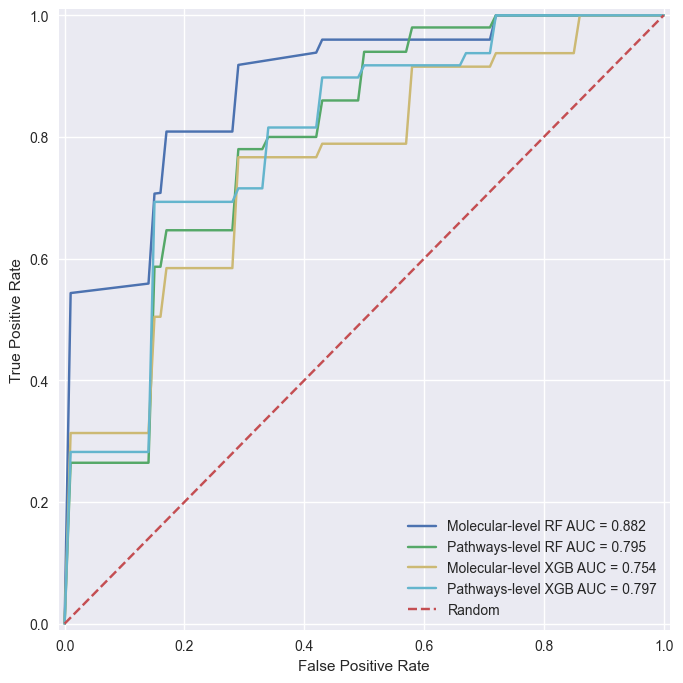

In [66]:
# Modify the ROC curve plotting code
plt.figure(figsize=(7,7))
# Update the style to a valid style name
plt.style.use("seaborn-v0_8")  # or use sns.set_theme() instead


roc_auc = auc(base_fpr, mean_tprs) #Molecular-level
roc_auc_p = auc(base_fpr_p, mean_tprs_p) # Pathways-level GSEA
roc_auc_xgb = auc(base_fpr_xgb, mean_tprs_xgb) #Molecular-level
roc_auc_p_xgb = auc(base_fpr_p_xgb, mean_tprs_p_xgb) # Pathways-level GSEA

# # Make sure all these variables exist:
# roc_auc = auc(base_fpr, mean_tprs)           # Molecular-level RF
# roc_auc_p = auc(base_fpr_p, mean_tprs_p)     # Pathways-level RF
# roc_auc_xgb = auc(base_fpr_xgb, mean_tprs_xgb)       # Molecular-level XGB
# roc_auc_p_xgb = auc(base_fpr_p_xgb, mean_tprs_p_xgb) # Pathways-level XGB

plt.figure(figsize=(7,7))
plt.style.use("seaborn-v0_8")
plt.plot(base_fpr, mean_tprs, 'b', label=f"Molecular-level RF AUC = {roc_auc:.3f}")
plt.plot(base_fpr_p, mean_tprs_p, 'g', label=f"Pathways-level RF AUC = {roc_auc_p:.3f}")
plt.plot(base_fpr_xgb, mean_tprs_xgb, 'y', label=f"Molecular-level XGB AUC = {roc_auc_xgb:.3f}")
plt.plot(base_fpr_p_xgb, mean_tprs_p_xgb, 'c', label=f"Pathways-level XGB AUC = {roc_auc_p_xgb:.3f}")

#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
#plt.fill_between(base_fpr_p, tprs_lower_p, tprs_upper_p, color='grey', alpha=0.2)
#plt.fill_between(base_fpr_xgb, tprs_lower_xgb, tprs_upper_xgb, color='grey', alpha=0.2)
#plt.fill_between(base_fpr_p_xgb, tprs_lower_p_xgb, tprs_upper_p_xgb, color='grey', alpha=0.2)

plt.plot([0, 1], [0, 1],'r--', label='Random')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/roc_curve.png", dpi=300)
plt.show()

# differential pathway scores 

In [89]:
scores = ssgsea_results(key_modules_genes.iloc[:, :-2], pathways_present).T
de_res_path = t_tests(scores, key_modules_genes["Group"], "fdr_bh")
de_res_path.sort_values(by="P-adjust")["Pathway"][:30].map(pathway_names).tolist()

ℹ GSVA version 2.2.0
ℹ Calculating  ssGSEA scores for 905 gene sets
ℹ Calculating ranks
ℹ Calculating rank weights
ℹ Normalizing ssGSEA scores
✔ Calculations finished
905


/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T/ipykernel_73670/559694277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease.drop(['Target'], axis=1, inplace=True)
/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T/ipykernel_73670/559694277.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl.drop(['Target'], axis=1, inplace=True)


['Plasma lipoprotein remodeling',
 'HDL remodeling',
 'Plasma lipoprotein assembly, remodeling, and clearance',
 'Interleukin-37 signaling',
 'Bile acid and bile salt metabolism',
 'Synthesis of bile acids and bile salts',
 'Transcriptional  activation of  cell cycle inhibitor p21 ',
 'Transcriptional activation of p53 responsive genes  ',
 'Respiratory electron transport',
 'Striated Muscle Contraction',
 'Synthesis of IP3 and IP4 in the cytosol',
 'Transport of inorganic cations/anions and amino acids/oligopeptides',
 'Aerobic respiration and respiratory electron transport',
 'Transcriptional regulation by the AP-2 (TFAP2) family of transcription factors',
 'Synthesis of bile acids and bile salts via 7alpha-hydroxycholesterol',
 'Signaling by NOTCH1 PEST Domain Mutants in Cancer',
 'Signaling by NOTCH1 in Cancer',
 'NOTCH1 Intracellular Domain Regulates Transcription',
 'Constitutive Signaling by NOTCH1 HD+PEST Domain Mutants',
 'Signaling by NOTCH1',
 'Paracetamol ADME',
 'Signaling

In [77]:
de_res_path

['Plasma lipoprotein remodeling',
 'HDL remodeling',
 'Plasma lipoprotein assembly, remodeling, and clearance',
 'Interleukin-37 signaling',
 'Bile acid and bile salt metabolism',
 'Synthesis of bile acids and bile salts',
 'Transcriptional  activation of  cell cycle inhibitor p21 ',
 'Transcriptional activation of p53 responsive genes  ',
 'Respiratory electron transport',
 'Striated Muscle Contraction',
 'Synthesis of IP3 and IP4 in the cytosol',
 'Transport of inorganic cations/anions and amino acids/oligopeptides',
 'Aerobic respiration and respiratory electron transport',
 'Transcriptional regulation by the AP-2 (TFAP2) family of transcription factors',
 'Synthesis of bile acids and bile salts via 7alpha-hydroxycholesterol',
 'Signaling by NOTCH1 PEST Domain Mutants in Cancer',
 'Signaling by NOTCH1 in Cancer',
 'NOTCH1 Intracellular Domain Regulates Transcription',
 'Constitutive Signaling by NOTCH1 HD+PEST Domain Mutants',
 'Signaling by NOTCH1',
 'Paracetamol ADME',
 'Signaling

In [82]:
scores

R-HSA-1059683  R-HSA-109581  R-HSA-109582  R-HSA-109606  \
Unnamed: 0                                                            
GTEX-11EMC      -0.071911      0.114541      0.071063      0.344953   
GTEX-11GS4       0.006684      0.004610      0.007758     -0.323637   
GTEX-11GSO      -0.408567      0.088713      0.068121      0.131024   
GTEX-11OF3      -0.261048     -0.116449     -0.031998     -0.251090   
GTEX-11ONC      -0.062561      0.031572      0.028448     -0.143806   
...                   ...           ...           ...           ...   
GTEX-T6MN       -0.252360      0.055354     -0.080906     -0.262301   
GTEX-WL46       -0.065660     -0.007569     -0.055394     -0.094550   
GTEX-YFC4        0.160087      0.038318     -0.086749     -0.289646   
GTEX-ZAK1        0.112110     -0.012387      0.054527     -0.313205   
GTEX-ZUA1       -0.007603     -0.177519      0.044608     -0.199111   

            R-HSA-109704  R-HSA-110056  R-HSA-111885  R-HSA-112040  \
Unnamed: 0                                                           
GTEX-11EMC     -0.077490     -0.116408      0.158551      0.273667   
GTEX-11GS4     -0.365291     -0.034808     -0.067336     -0.181287   
GTEX-11GSO     -0.201706     -0.195304      0.076274      0.268747   
GTEX-11OF3     -0.042081     -0.277632      0.138792      0.072506   
GTEX-11ONC      0.234531     -0.100899      0.013523      0.143220   
...                  ...           ...           ...           ...   
GTEX-T6MN       0.146862     -0.244074     -0.139970     -0.315936   
GTEX-WL46       0.170051      0.012425     -0.025243     -0.355168   
GTEX-YFC4       0.183025      0.167843     -0.055626     -0.222579   
GTEX-ZAK1       0.109988      0.121481      0.018042     -0.206669   
GTEX-ZUA1       0.049130      0.068977      0.017394     -0.133916   

            R-HSA-112043  R-HSA-112310  ...  R-HSA-9925563  R-HSA-9926550  \
Unnamed: 0                              ...                                 
GTEX-11EMC      0.273667      0.130472  ...       0.196835       0.296030   
GTEX-11GS4     -0.181287     -0.038105  ...      -0.243697      -0.347509   
GTEX-11GSO      0.268747     -0.047727  ...       0.010590       0.080240   
GTEX-11OF3      0.072506     -0.030730  ...      -0.206702      -0.198343   
GTEX-11ONC      0.143220      0.056657  ...       0.153510      -0.057884   
...                  ...           ...  ...            ...            ...   
GTEX-T6MN      -0.315936     -0.017838  ...      -0.024838      -0.191040   
GTEX-WL46      -0.355168      0.015097  ...       0.087252      -0.156300   
GTEX-YFC4      -0.222579      0.074351  ...      -0.027183      -0.110498   
GTEX-ZAK1      -0.206669     -0.070510  ...      -0.051365       0.286734   
GTEX-ZUA1      -0.133916      0.100972  ...      -0.004331       0.026929   

            R-HSA-9927020  R-HSA-9927432  R-HSA-9931509  R-HSA-9931953  \
Unnamed: 0                                                               
GTEX-11EMC       0.241504       0.068064       0.342073       0.028566   
GTEX-11GS4       0.460748       0.129672      -0.033357      -0.086908   
GTEX-11GSO      -0.333347       0.082943       0.021831      -0.074593   
GTEX-11OF3      -0.054572       0.096717      -0.002400      -0.225341   
GTEX-11ONC       0.476901       0.199203       0.003172       0.250850   
...                   ...            ...            ...            ...   
GTEX-T6MN        0.041205       0.082804      -0.163234       0.185509   
GTEX-WL46        0.055910      -0.065001      -0.204640       0.251713   
GTEX-YFC4        0.078053      -0.105454      -0.035909      -0.072631   
GTEX-ZAK1        0.086648       0.105144      -0.349745      -0.301850   
GTEX-ZUA1        0.443673       0.206885      -0.247186       0.104251   

            R-HSA-9933387  R-HSA-9937080  R-HSA-997272  Target  
Unnamed: 0                                                      
GTEX-11EMC       0.313210       0.127154      0.058680       0  
GTEX-11GS4      -

In [90]:
top30paths = de_res_path.sort_values(by="P-adjust")["Pathway"][:30]
scores = scores.loc[:, top30paths]

# top30paths = ['Plasma lipoprotein remodeling',
#  'HDL remodeling',
#  'Respiratory electron transport',
#  'Interleukin-37 signaling',
#  'Bile acid and bile salt metabolism',
#  'Transcriptional activation of p53 responsive genes  ',
#  'The citric acid (TCA) cycle and respiratory electron transport',
#  'Synthesis of IP3 and IP4 in the cytosol',
#  'Signaling by NOTCH1',
#  'Glycogen metabolism']


data = scores
data.rename(columns=pathway_names, inplace=True)
# Map pathway IDs to names before selecting top30 columns
data = data.rename(columns=pathway_names)
# Reset index and use the correct index name for melt
data = data[top30paths.map(pathway_names)]
data = data.reset_index()

index_col = data.columns[0]  # This will be the name of the index column after reset_index()

data = data.melt(id_vars=index_col,
    var_name="Pathway", 
    value_name="Value").set_index(index_col)


data["Group"] = key_modules_genes["Group"]

df = data



In [91]:
pathway_names

{'R-HSA-1643685': 'Disease',
 'R-HSA-5663205': 'Infectious disease',
 'R-HSA-9638737': 'Action of antimicrobials and antimicrobial resistance',
 'R-HSA-9638771': 'Action of antimicrobials',
 'R-HSA-9640148': 'Infection with Enterobacteria',
 'R-HSA-9824439': 'Bacterial Infection Pathways',
 'R-HSA-162699': 'Synthesis of dolichyl-phosphate mannose',
 'R-HSA-163125': 'Post-translational modification: synthesis of GPI-anchored proteins',
 'R-HSA-3781865': 'Diseases of glycosylation',
 'R-HSA-392499': 'Metabolism of proteins',
 'R-HSA-446193': 'Biosynthesis of the N-glycan precursor (dolichol lipid-linked oligosaccharide, LLO) and transfer to a nascent protein',
 'R-HSA-446203': 'Asparagine N-linked glycosylation',
 'R-HSA-446219': 'Synthesis of substrates in N-glycan biosythesis',
 'R-HSA-4717374': 'Defective DPM1 causes DPM1-CDG',
 'R-HSA-4719360': 'Defective DPM3 causes DPM3-CDG',
 'R-HSA-4719377': 'Defective DPM2 causes DPM2-CDG',
 'R-HSA-5609975': 'Diseases associated with glycosylati

/var/folders/5g/7gzv8rg14tv7prkqk0v2f3280000gn/T/ipykernel_73670/5111043.py:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.25'` for the same effect.

  sns.swarmplot(x='Pathway', y='Value', data=df, hue = 'Group', color=".25", dodge=True)
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/new_base/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


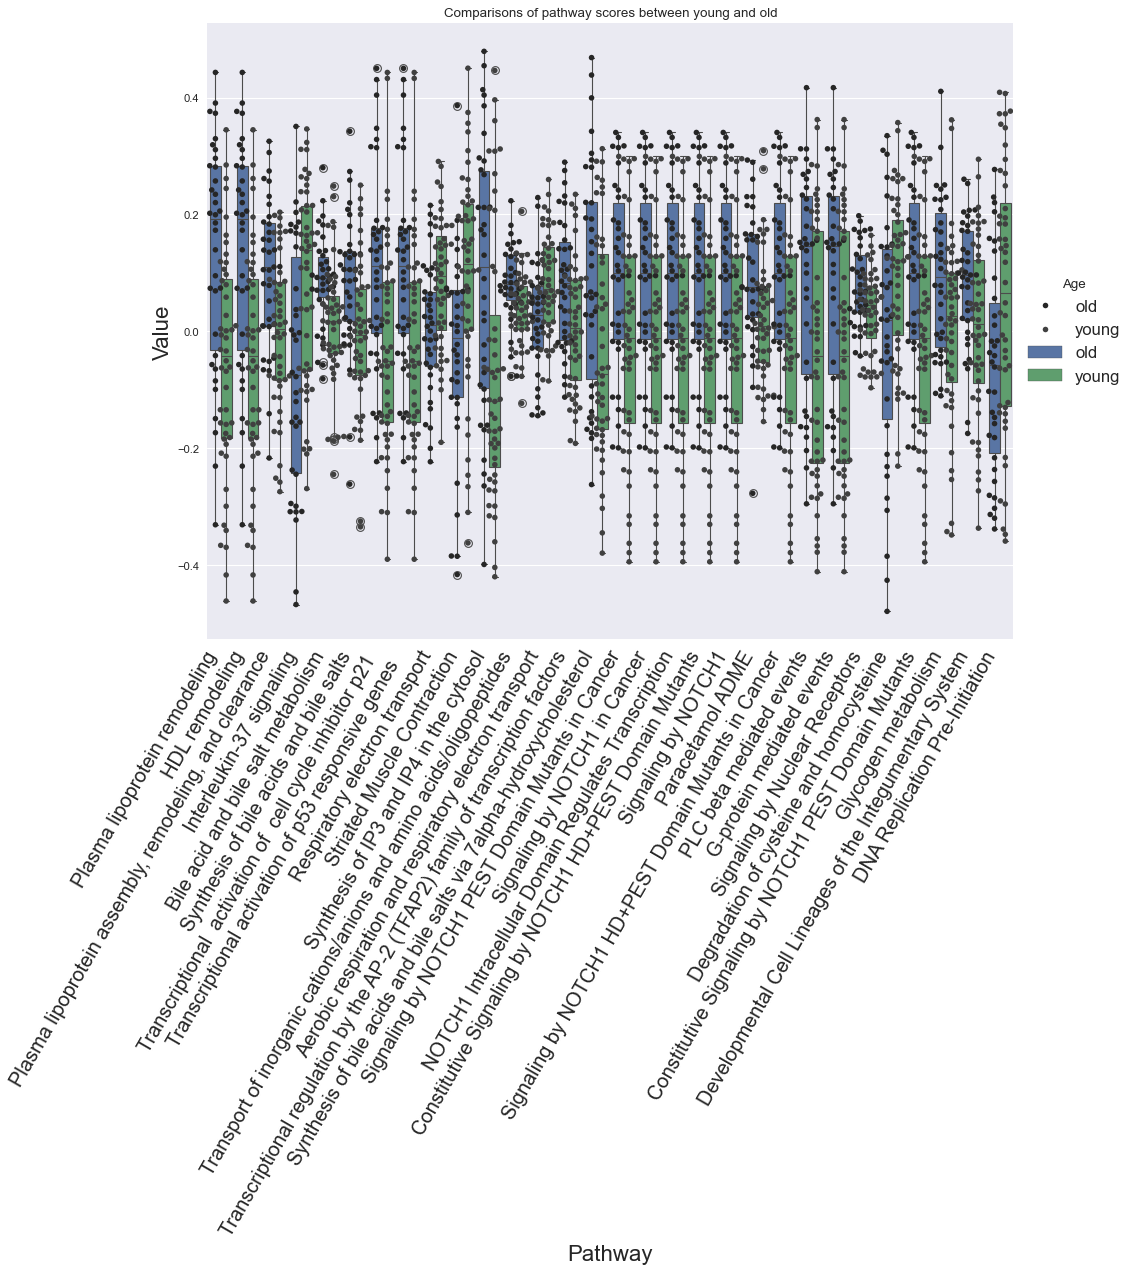

In [92]:

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)

#ax= sns.swarmplot(x='Pathway', y='Value', data=df, hue='Group', dodge=True)
sns.swarmplot(x='Pathway', y='Value', data=df, hue = 'Group', color=".25", dodge=True)

ax = sns.boxplot(x='Pathway', y='Value', data=df, hue='Group')

#sns.stripplot(x='Pathway', y='Value', data=df, color='black', size=3, jitter=1)

#for i in range(len(df['Group'].unique())-1):
#    plt.vlines(i+.5, 1, 10, linestyles='solid', colors='gray', alpha=0.2)

# Decoration
plt.title('Comparisons of pathway scores between young and old')
plt.legend(title='Age')
plt.xticks(rotation=60, ha='right', fontsize=18)
plt.legend(prop={'size': 15}, title = 'Age', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Pathway', fontsize=20)

plt.ylabel('Value', fontsize=20)

plt.savefig(f"plots/Comparisons of pathway scores between young and old.png", bbox_inches='tight', dpi=300)


plt.show()